In [1]:
import os

import numpy as np
np.random.seed(10)

# Plotting
import matplotlib.pyplot as plt

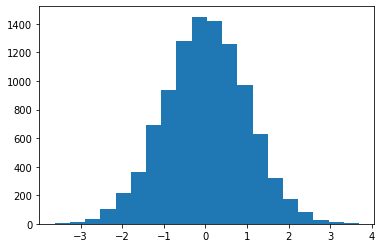

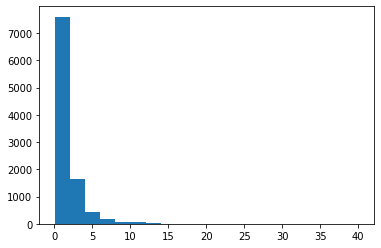

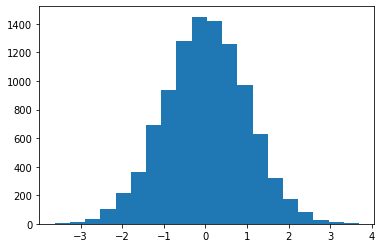

In [2]:
# Sample a Gaussian
mu, sigma = 0.0, 1.0
z_samples = np.random.normal(mu, sigma, 10000)

plt.figure()
plt.hist(z_samples,bins=20)
plt.show()

# Transform the samples through an invertible function applied on the support
x_samples = np.exp(z_samples)
plt.figure()
plt.hist(x_samples,bins=20)
plt.show()

# Invert the transformation and plot
z_samples_inv = np.log(x_samples)
plt.figure()
plt.hist(z_samples_inv,bins=20)
plt.show()

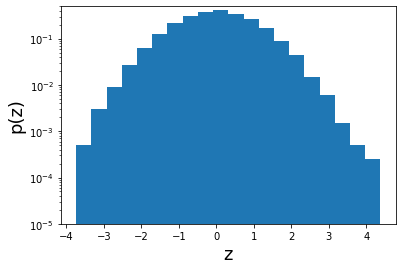

Transformations at time = 1


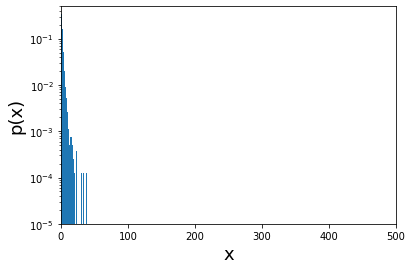

Transformations at time = 2


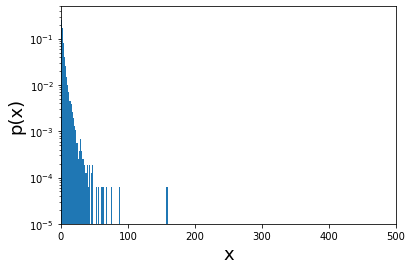

Transformations at time = 3


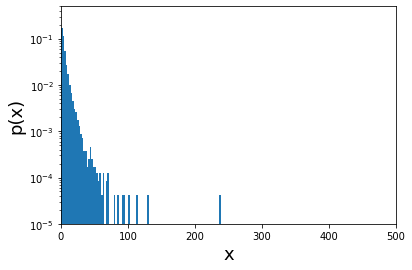

Transformations at time = 4


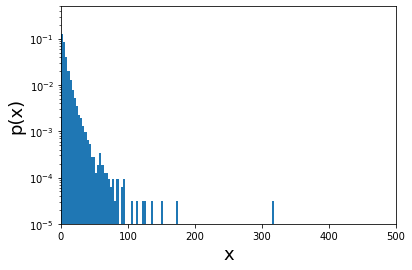

Transformations at time = 5


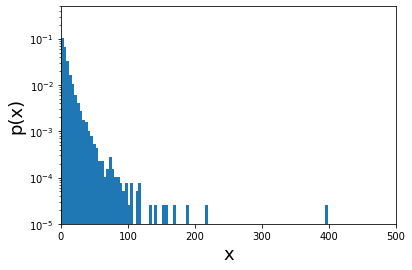

Transformations at time = 6


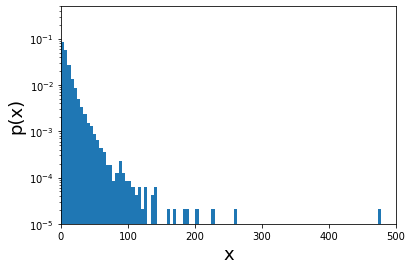

Transformations at time = 7


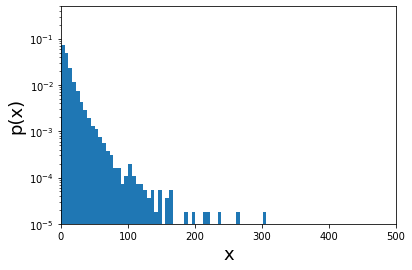

Transformations at time = 8


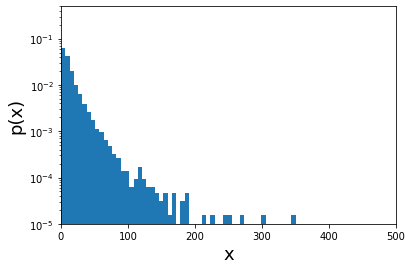

Transformations at time = 9


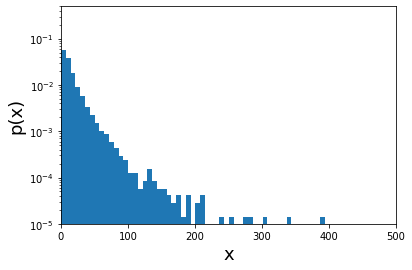

Transformations at time = 10


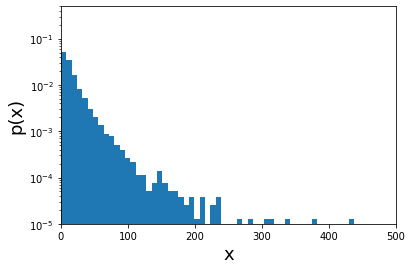

Transformations at time = 11


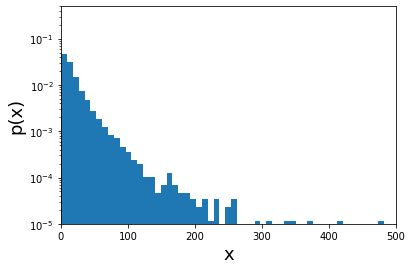

Transformations at time = 12


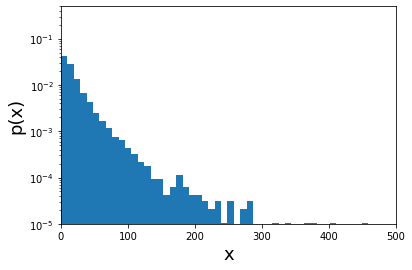

Transformations at time = 13


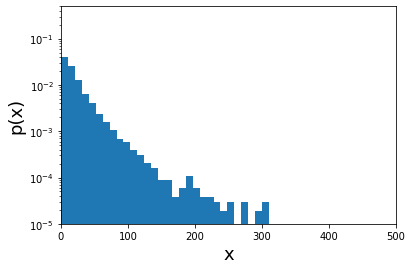

Transformations at time = 14


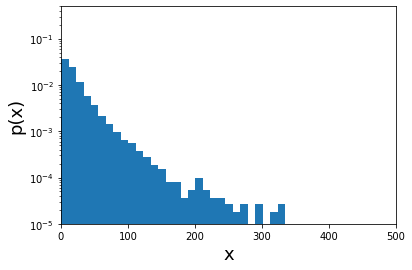

Transformations at time = 15


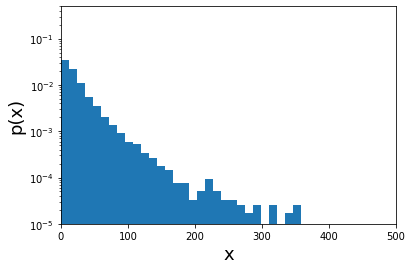

Transformations at time = 16


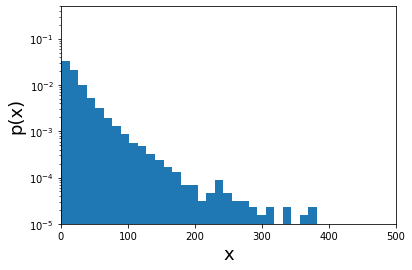

Transformations at time = 17


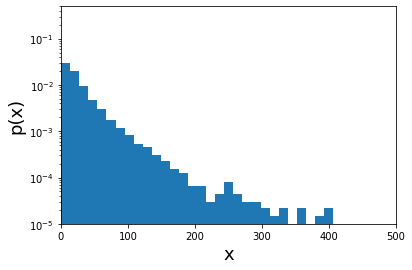

Transformations at time = 18


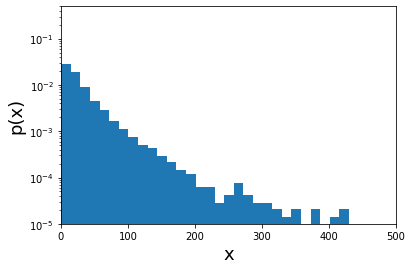

Transformations at time = 19


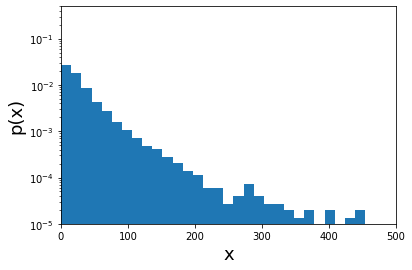

Transformations at time = 20


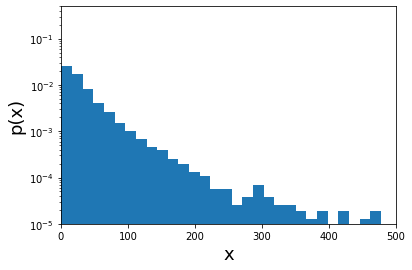

Transformations at time = 21


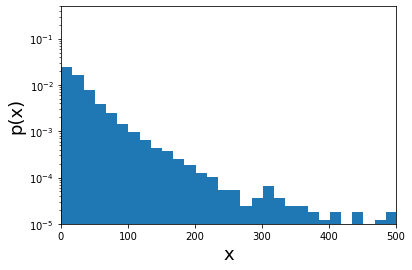

Transformations at time = 22


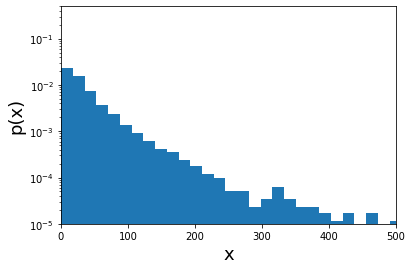

Transformations at time = 23


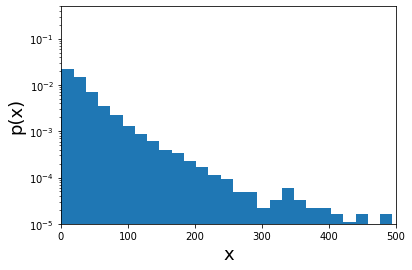

Transformations at time = 24


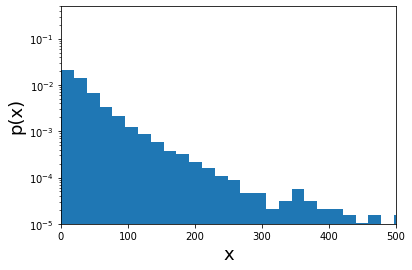

Transformations at time = 25


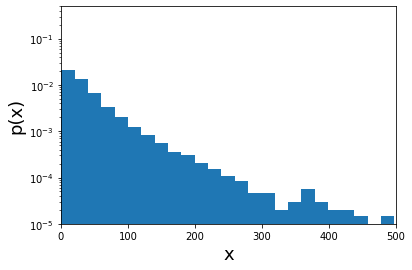

Transformations at time = 26


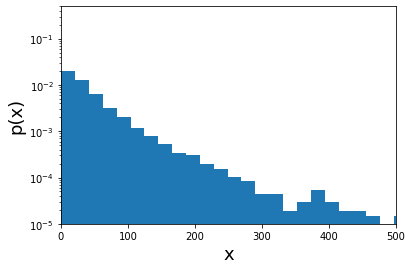

Transformations at time = 27


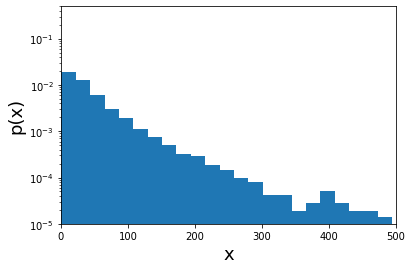

Transformations at time = 28


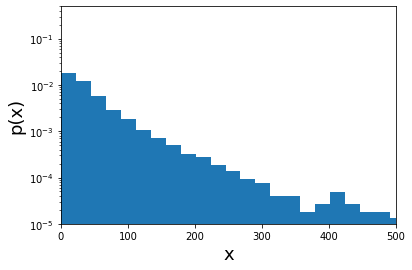

Transformations at time = 29


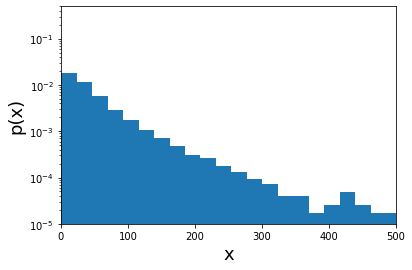

In [13]:
# Lets do a time-varying map --- x = f(z,t) = t e^z, z = ln(x/t)
# the Gaussian samples remain the same (the source is time-invariant)
mu, sigma = 0.0, 1.0
z_samples = np.random.normal(mu, sigma, 10000)
plt.figure()
plt.hist(z_samples,bins=20,density=True)
plt.yscale('log')
plt.ylim(0.00001,0.5)
plt.xlabel('z',fontsize=18)
plt.ylabel('p(z)',fontsize=18)
plt.savefig('p_z.png')
plt.show()

for t in np.arange(1,30,step=1):
    print('Transformations at time =', t)
    
    # Transform the samples through an invertible function (of space and time) applied on the support
    x_samples = np.exp(z_samples)*t
    plt.figure()
    plt.hist(x_samples,bins=100,density=True)
    plt.yscale('log')
    plt.xlim(0,500)
    plt.xlabel('x',fontsize=18)
    plt.ylabel('p(x)',fontsize=18)
    plt.ylim(0.00001,0.5)
    plt.savefig('p_x_'+str(t)+'.png')
    plt.show()
    
#     # Invert the transformation and plot
#     z_samples_inv = np.log(x_samples/t)
#     plt.figure()
#     plt.hist(z_samples_inv,bins=20)
#     plt.show()    

In [14]:
'''
Lets do the gradient business here
x = t e^z
z = log(x/t)
dz/dt = -1/t
dz^2/dt^2 = 1/t^2
dz/dx = 1/x -> Not needed
dz^2/dx^2 = -1/x^2 -> Not needed
'''
# Selecting points evenly now (since we presumably have these gradient relationships for example by training)
z = []
dzdt = []
dz2dt2 = []

for t in np.arange(1,30,step=1):
    z_ = np.arange(start=-4, stop=4.0, step=0.1).reshape(-1,1)
    dzdt_ = np.zeros(shape=np.shape(z_))-1/t
    dz2dt2_ = np.zeros(shape=np.shape(z_))+1/(t**2)
    
    z.append(z_)
    dzdt.append(dzdt_)
    dz2dt2.append(dz2dt2_)
    
z = np.asarray(z)[:,:,0].T
dzdt = np.asarray(dzdt)[:,:,0].T
dz2dt2 = np.asarray(dz2dt2)[:,:,0].T

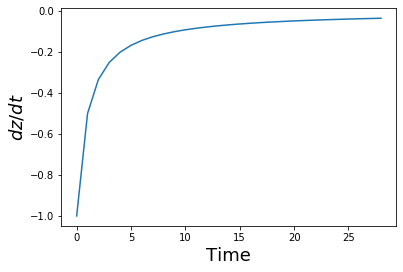

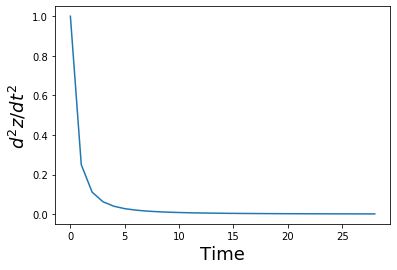

In [15]:
# plt.figure()
# plt.imshow(z)
# plt.ylabel('z')
# plt.xlabel('t')
# plt.colorbar()
# plt.show()

# plt.figure()
# plt.imshow(dzdt)
# plt.ylabel('z')
# plt.xlabel('t')
# plt.colorbar()
# plt.show()

plt.figure()
plt.plot(dzdt[40,:])
plt.xlabel('Time',fontsize=18)
plt.ylabel('$dz/dt$',fontsize=18)
plt.savefig('z_dot.png')
plt.show()

# plt.figure()
# plt.imshow(dz2dt2)
# plt.ylabel('z')
# plt.xlabel('t')
# plt.colorbar()
# plt.show()

plt.figure()
plt.plot(dz2dt2[40,:])
plt.xlabel('Time',fontsize=18)
plt.ylabel('$d^2 z/ d t^2$',fontsize=18)
plt.savefig('z_ddot.png')
plt.show()

In [ ]:
'''
Let's build the worlds simplest "invertible neural network" and try to learn x = f(z,t)"
Let our one input be z and the other be t

'''
import tensorflow as tf
tf.random.set_seed(10)
from tensorflow.keras import Model


#Build the model which does basic map of inputs to coefficients
class normalizing_flow(Model):
    def __init__(self,data):
        super(normalizing_flow, self).__init__()

        self.dim = data.shape[1]
        self.scale_dim = int(self.dim/2)
        self.data = data

        # Define real_nvp flow layers
        self.scale_weight_0 = tf.keras.layers.Dense(10,activation='tanh')
        self.scale_weight_1 = tf.keras.layers.Dense(1,activation='linear')
        self.trans_weight_0 = tf.keras.layers.Dense(10,activation='tanh')
        self.trans_weight_1 = tf.keras.layers.Dense(1,activation='linear')
        
        # Training optimizer
        self.train_op = tf.keras.optimizers.Adam(learning_rate=0.0001)


    @tf.function
    def call(self, inputs): # inputs = [x,t]
               
        with tf.GradientTape(persistent=True) as t:
            t.watch(inputs)
            
            h1 = self.scale_weight_0(inputs)
            h1 = self.scale_weight_1(h1)

            h2 = self.trans_weight_0(inputs)
            h2 = self.trans_weight_1(h2)
        
            op = tf.math.exp(h1*inputs[:,0]) + h2
            
            dh1dx = t.gradient(h1, inputs)[:,0]
            dh2dx = t.gradient(h2, inputs)[:,0]
        
            # Logdet value
            logdet = tf.math.log(tf.math.exp(h1*inputs[:,0])*dh1dx + h2 + inputs[:,0]*dh2dx)

        log_prior = -0.5*tf.math.reduce_sum(tf.math.square(op))

        neg_ll = - log_prior - logdet

        return op, neg_ll

    @tf.function
    def sample(self,size,t):
        z = tf.random.normal(shape=(size,1)) # one dimension for time

        return h

    # perform gradient descent
    def network_learn(self,x):

        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            _, neg_ll = self.call(x)
            g = tape.gradient(neg_ll, self.trainable_variables)

        self.train_op.apply_gradients(zip(g, self.trainable_variables))

    # Train the model
    def train_model(self):
        plot_iter = 0
        stop_iter = 0
        patience = 100
        best_valid_loss = np.inf # Some large number 

        self.num_batches = 10
        self.ntrain = int(0.7*self.data.shape[0])
        self.nvalid = self.data.shape[0] - int(0.7*self.data.shape[0])

        self.train_data = self.data[:self.ntrain]
        self.valid_data = self.data[self.ntrain:]

        self.train_batch_size = int(self.ntrain/self.num_batches)
        self.valid_batch_size = int(self.ntrain/self.num_batches)
        
        for i in range(1000):
            # Training loss
            print('Training iteration:',i)
            
            for batch in range(self.num_batches):
                batch_data = self.train_data[batch*self.train_batch_size:(batch+1)*self.train_batch_size]
                self.network_learn(batch_data)

            # Validation loss
            valid_loss = 0.0

            for batch in range(self.num_batches):
                batch_data = self.valid_data[batch*self.valid_batch_size:(batch+1)*self.valid_batch_size]
                valid_loss = valid_loss + np.sum(self.call(batch_data)[1].numpy())

            # Check early stopping criteria
            if valid_loss < best_valid_loss:
                
                print('Improved validation loss from:',best_valid_loss,' to:', valid_loss)
                
                best_valid_loss = valid_loss

                self.save_weights('./checkpoints/my_checkpoint')
                
                stop_iter = 0
            else:
                print('Validation loss (no improvement):',valid_loss)
                stop_iter = stop_iter + 1

            if stop_iter == patience:
                break
